In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movie-lens-small-latest-dataset/movies.csv
/kaggle/input/movie-lens-small-latest-dataset/ratings.csv
/kaggle/input/movie-lens-small-latest-dataset/README.txt
/kaggle/input/movie-lens-small-latest-dataset/tags.csv
/kaggle/input/movie-lens-small-latest-dataset/links.csv


In [2]:
import numpy as pandas 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors


In [3]:
df_movies =pd.read_csv("../input/movie-lens-small-latest-dataset/movies.csv")
print("Movies_shape:",df_movies.shape)
df_links =pd.read_csv("../input/movie-lens-small-latest-dataset/links.csv")
print("Links_shape:",df_links.shape)
df_rating =pd.read_csv("../input/movie-lens-small-latest-dataset/ratings.csv")
print("Rating_shape:",df_rating.shape)
df_tags=pd.read_csv("../input/movie-lens-small-latest-dataset/tags.csv")
print("Tags_shape:",df_tags.shape)

Movies_shape: (9742, 3)
Links_shape: (9742, 3)
Rating_shape: (100836, 4)
Tags_shape: (3683, 4)


In [4]:
df_movies.head(5)


movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [5]:
df_links.head(5)

movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0

Movie dataset has

movieId - unique id for every movies.
genres - not required for recommendation.

In [6]:
df_rating.head(5)

userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Ratings dataset has

userId - unique for each user
movieId - using this feature ,we take the title of the movie from movies dataset
rating - Ratings given by each user to all the movies using this we are going to predict the top 10 similar movies

In [7]:
df_tags.head()

userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
4       2    89774              MMA  1445715200

In [8]:
final_data =df_rating.pivot(index='movieId',columns='userId',values='rating')
final_data.head()

userId   1    2    3    4    5    6    7    8    9    10   ...  601  602  603  \
movieId                                                    ...                  
1        4.0  NaN  NaN  NaN  4.0  NaN  4.5  NaN  NaN  NaN  ...  4.0  NaN  4.0   
2        NaN  NaN  NaN  NaN  NaN  4.0  NaN  4.0  NaN  NaN  ...  NaN  4.0  NaN   
3        4.0  NaN  NaN  NaN  NaN  5.0  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
4        NaN  NaN  NaN  NaN  NaN  3.0  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
5        NaN  NaN  NaN  NaN  NaN  5.0  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   

userId   604  605  606  607  608  609  610  
movieId                                     
1        3.0  4.0  2.5  4.0  2.5  3.0  5.0  
2        5.0  3.5  NaN  NaN  2.0  NaN  NaN  
3        NaN  NaN  NaN  NaN  2.0  NaN  NaN  
4        NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5        3.0  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 610 columns]

In [9]:
final_data =final_data.fillna(0)
final_data.shape

(9724, 610)

In [10]:
final_data.head()

userId   1    2    3    4    5    6    7    8    9    10   ...  601  602  603  \
movieId                                                    ...                  
1        4.0  0.0  0.0  0.0  4.0  0.0  4.5  0.0  0.0  0.0  ...  4.0  0.0  4.0   
2        0.0  0.0  0.0  0.0  0.0  4.0  0.0  4.0  0.0  0.0  ...  0.0  4.0  0.0   
3        4.0  0.0  0.0  0.0  0.0  5.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4        0.0  0.0  0.0  0.0  0.0  3.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
5        0.0  0.0  0.0  0.0  0.0  5.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

userId   604  605  606  607  608  609  610  
movieId                                     
1        3.0  4.0  2.5  4.0  2.5  3.0  5.0  
2        5.0  3.5  0.0  0.0  2.0  0.0  0.0  
3        0.0  0.0  0.0  0.0  2.0  0.0  0.0  
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5        3.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 610 columns]

**Exploratory_DATA_Analysis**


In [11]:
df_rate_merge =pd.merge(df_rating,df_movies,on='movieId')
df_rate_merge.head()

userId  movieId  rating   timestamp             title  \
0       1        1     4.0   964982703  Toy Story (1995)   
1       5        1     4.0   847434962  Toy Story (1995)   
2       7        1     4.5  1106635946  Toy Story (1995)   
3      15        1     2.5  1510577970  Toy Story (1995)   
4      17        1     4.5  1305696483  Toy Story (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1  Adventure|Animation|Children|Comedy|Fantasy  
2  Adventure|Animation|Children|Comedy|Fantasy  
3  Adventure|Animation|Children|Comedy|Fantasy  
4  Adventure|Animation|Children|Comedy|Fantasy

In [12]:
df_rate_merge.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Gena the Crocodile (1969)              5.0
True Stories (1986)                    5.0
Cosmic Scrat-tastrophe (2015)          5.0
Love and Pigeons (1985)                5.0
Red Sorghum (Hong gao liang) (1987)    5.0
Name: rating, dtype: float64

In [13]:
df_rate_merge.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: rating, dtype: int64

In [14]:
rating =pd.DataFrame(df_rate_merge.groupby('title')['rating'].mean())
rating.head()

rating
title                                          
'71 (2014)                                  4.0
'Hellboy': The Seeds of Creation (2004)     4.0
'Round Midnight (1986)                      3.5
'Salem's Lot (2004)                         5.0
'Til There Was You (1997)                   4.0

In [15]:
rating['count_rating']=pd.DataFrame(df_rate_merge.groupby('title')['rating'].count())

In [16]:
rating.head()

rating  count_rating
title                                                        
'71 (2014)                                  4.0             1
'Hellboy': The Seeds of Creation (2004)     4.0             1
'Round Midnight (1986)                      3.5             2
'Salem's Lot (2004)                         5.0             1
'Til There Was You (1997)                   4.0             2

<AxesSubplot:>

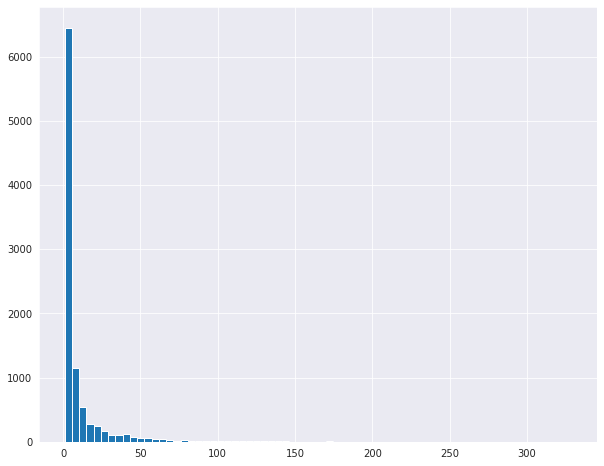

In [17]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,8))
rating['count_rating'].hist(bins=70)

<AxesSubplot:>

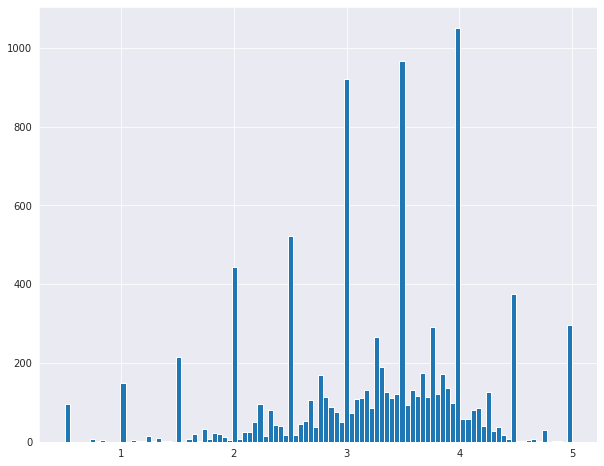

In [18]:
plt.figure(figsize=(10,8))
rating['rating'].hist(bins=100)

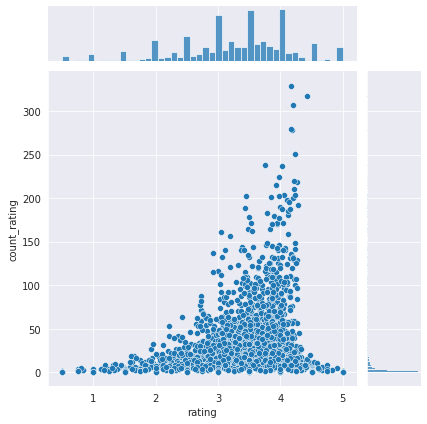

In [19]:
sns.jointplot(x='rating',y='count_rating',data=rating)

In [20]:
no_user_voted= df_rating.groupby('movieId')['rating'].agg('count')
no_movies_voted = df_rating.groupby('userId')['rating'].agg('count')

In [21]:
final_data.head()

userId   1    2    3    4    5    6    7    8    9    10   ...  601  602  603  \
movieId                                                    ...                  
1        4.0  0.0  0.0  0.0  4.0  0.0  4.5  0.0  0.0  0.0  ...  4.0  0.0  4.0   
2        0.0  0.0  0.0  0.0  0.0  4.0  0.0  4.0  0.0  0.0  ...  0.0  4.0  0.0   
3        4.0  0.0  0.0  0.0  0.0  5.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4        0.0  0.0  0.0  0.0  0.0  3.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
5        0.0  0.0  0.0  0.0  0.0  5.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

userId   604  605  606  607  608  609  610  
movieId                                     
1        3.0  4.0  2.5  4.0  2.5  3.0  5.0  
2        5.0  3.5  0.0  0.0  2.0  0.0  0.0  
3        0.0  0.0  0.0  0.0  2.0  0.0  0.0  
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5        3.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 610 columns]

To reduce the noise we are applying filter on data to get more accurate result
To qualify a movie, minimum 50 users should have voted a movie.
To qualify a user, minimum 50 movies should have voted by the user.

In [22]:
final_data= final_data.loc[no_user_voted[no_user_voted > 10].index,:]
final_data.loc[:,no_movies_voted[no_movies_voted > 50].index]

userId   1    4    6    7    10   11   15   16   17   18   ...  600  601  602  \
movieId                                                    ...                  
1        4.0  0.0  0.0  4.5  0.0  0.0  2.5  0.0  4.5  3.5  ...  2.5  4.0  0.0   
2        0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  3.0  ...  4.0  0.0  4.0   
3        4.0  0.0  5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
5        0.0  0.0  5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  2.5  0.0  0.0   
6        4.0  0.0  4.0  0.0  0.0  5.0  0.0  0.0  0.0  4.0  ...  0.0  0.0  3.0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
174055   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  4.0  0.0   
176371   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  4.0  0.0   
177765   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  4.5  0.0   
179819   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
187593   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

userId   603  604  605  606  607  608  610  
movieId                                     
1        4.0  3.0  4.0  2.5  4.0  2.5  5.0  
2        0.0  5.0  3.5  0.0  0.0  2.0  0.0  
3        0.0  0.0  0.0  0.0  0.0  2.0  0.0  
5        0.0  3.0  0.0  0.0  0.0  0.0  0.0  
6        4.0  3.0  0.0  0.0  0.0  0.0  5.0  
...      ...  ...  ...  ...  ...  ...  ...  
174055   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
176371   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
177765   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
179819   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
187593   0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[2121 rows x 378 columns]

In [23]:
csr_data = csr_matrix(final_data.values)
final_data.reset_index(inplace=True)

In [24]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, n_jobs=-1)

In [25]:
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=10)

In [26]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = df_movies[df_movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_data[final_data['movieId'] == movie_idx].index[0]
        
        distances,indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),\
                               key=lambda x: x[1])[:0:-1]
        
        recommend_frame = []
        
        for val in rec_movie_indices:
            movie_idx = final_data.iloc[val[0]]['movieId']
            idx = df_movies[df_movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':df_movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    
    else:
        
        return "No movies found. Please check your input"

In [27]:
get_movie_recommendation('Toy Story')

Title  Distance
1                           Back to the Future (1985)  0.469619
2                                Groundhog Day (1993)  0.465831
3                          Mission: Impossible (1996)  0.461087
4   Star Wars: Episode VI - Return of the Jedi (1983)  0.458911
5                               Lion King, The (1994)  0.458855
6                                 Forrest Gump (1994)  0.452904
7           Star Wars: Episode IV - A New Hope (1977)  0.442612
8                Independence Day (a.k.a. ID4) (1996)  0.435738
9                                Jurassic Park (1993)  0.434363
10                                 Toy Story 2 (1999)  0.427399